In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

In [28]:
# 2022.5.10
folders = ['common_5', 'common_3', 'common_1', 'batch1_1000', 'batch1_500', 'batch1_250', 'rare1_0.5', 'rare1_0.2', 'rare1_0.1', 'baseline']
simulation_list = ['Sim2']
print(simulation_list)
for dataname in simulation_list:
    for folder in folders:
        print(folder)
        if folder == 'baseline':
            adata = sc.read_loom('/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim/%s/%s_raw.loom' % (dataname, dataname), 
                                 sparse=False)  #Load cell line dataset(-> count data). 
        else:
            adata = sc.read_loom('/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim/%s/%s/%s_raw.loom' % (dataname, folder, dataname), 
                                 sparse=False)
        k2 = max(int((adata.obs.batch.value_counts().min())/100), 1)
        k1 = max(int(k2/2), 1)
        print('k1=%d, k2=%d' % (k1, k2))
        

['Sim2']
common_5
k1=6, k2=13
common_3
k1=5, k2=11
common_1
k1=4, k2=8
batch1_1000
k1=3, k2=7
batch1_500
k1=1, k2=3
batch1_250
k1=1, k2=1
rare1_0.5
k1=7, k2=14
rare1_0.2
k1=6, k2=13
rare1_0.1
k1=6, k2=13
baseline
k1=7, k2=15


In [26]:
adata.obs.batch.value_counts().min()

1561

In [5]:
base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim_new/Sim2'

In [6]:
count = pd.read_table('%s/counts.txt' % base_dir)
cellinfo = pd.read_table('%s/cellinfo.txt' % base_dir)
geneinfo = pd.read_table('%s/geneinfo.txt' % base_dir)

In [7]:
adata = sc.AnnData(count.values)
adata.obs = cellinfo[['Batch', 'Group', 'ExpLibSize']].rename(columns={'Batch': 'batch', 'Group': 'celltype'})
adata.var = geneinfo
adata.var_names.name = 'Gene'
adata.obs_names.name = 'CellID'

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata

AnnData object with n_obs × n_vars = 3131 × 7882
    obs: 'batch', 'celltype', 'ExpLibSize', 'n_genes'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'BatchFacBatch1', 'BatchFacBatch2', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'DEFacGroup7', 'n_cells'

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, 20, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


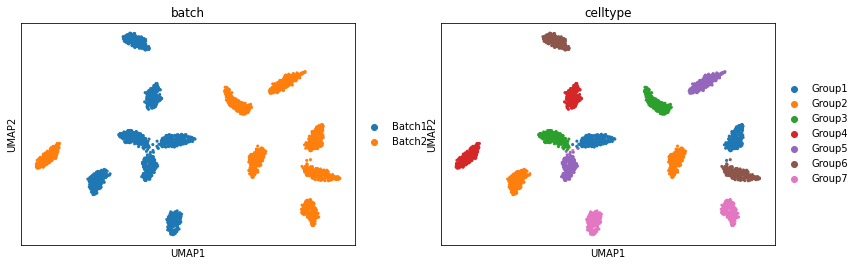

In [11]:
sc.pl.umap(adata, color=['batch', 'celltype'])

In [328]:
number = 3
common_ct = ['Group%d' % i for i in range(1, number+1)]
index0 = adata.obs_names[adata.obs.celltype.isin(common_ct)]
specific_number = 7 - number
# Get specific cell types for Batch1
specific_ct = ['Group%d' % i for i in range(number+1, int(number+1+specific_number/2))]
index1 = adata.obs_names[adata.obs.celltype.isin(specific_ct) & (adata.obs.batch=='Batch1')]
# Get specific cell types for Batch2
specific_ct = ['Group%d' % i for i in range(int(number+1+specific_number/2), 7+1)]
index2 = adata.obs_names[adata.obs.celltype.isin(specific_ct) & (adata.obs.batch=='Batch2')]
adata_sub = adata[index0.union(index1).union(index2)]
print(pd.crosstab(adata_sub.obs.celltype, adata_sub.obs.batch))
# adata_sub.write_loom('%s/common_%d/Sim%d_raw.loom' % (base_dir, number, seed))

batch     Batch1  Batch2
celltype                
Group1       251     222
Group2       242     225
Group3       238     217
Group4       222       0
Group5       215       0
Group6         0     236
Group7         0     212


In [329]:
print(pd.crosstab(adata.obs.celltype, adata.obs.batch))

batch     Batch1  Batch2
celltype                
Group1       251     222
Group2       242     225
Group3       238     217
Group4       222     219
Group5       215     237
Group6       207     236
Group7       206     212


Trying to set attribute `.obs` of view, copying.
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as cat

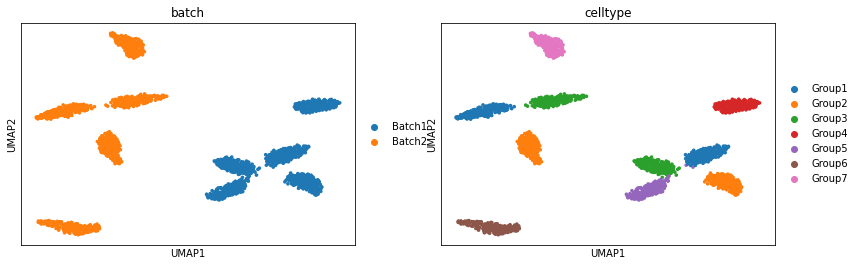

In [330]:
adata = adata_sub
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, 20, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['batch', 'celltype'])

/gpfs/gibbs/pi/zhao/yw599/venv_grace/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv_grace/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


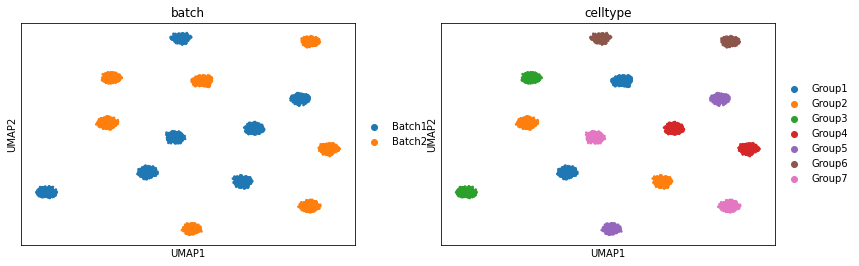

In [48]:
sc.pl.umap(adata, color=['batch', 'celltype'])

# Generate loom files

In [13]:
np.sum(np.sum(count == 0))/np.prod(count.shape)

0.9605568

In [14]:
count.shape

(4000, 10000)

In [16]:
for seed in range(2, 3):
    print('\n')
    print(seed)
    base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim_new/Sim%d' % seed
    count = pd.read_table('%s/counts.txt' % base_dir)
    cellinfo = pd.read_table('%s/cellinfo.txt' % base_dir)
    geneinfo = pd.read_table('%s/geneinfo.txt' % base_dir)
    adata = sc.AnnData(count.values)
    adata.obs = cellinfo[['Batch', 'Group', 'ExpLibSize']].rename(columns={'Batch': 'batch', 'Group': 'celltype'})
    adata.var = geneinfo
    adata.var_names.name = 'Gene'
    adata.obs_names.name = 'CellID'
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    print('zero prop: ', np.sum(np.sum(adata.X == 0))/np.prod(adata.shape))
    print(adata.shape)
    adata.write_loom('%s/Sim%d_raw.loom' % (base_dir, seed))



2
zero prop:  0.9410774348014562
(3131, 7882)




1
(4000, 10000)
zero prop:  0.950152672467371
(3218, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


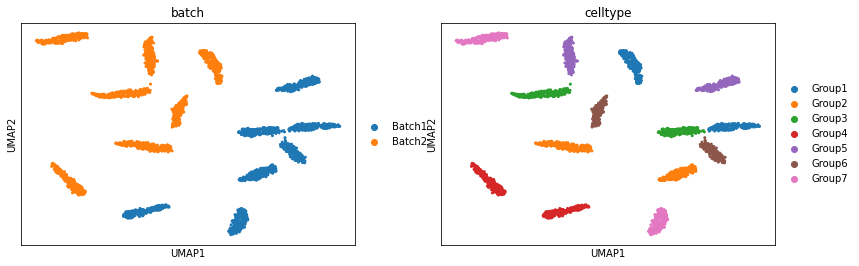



2
(4000, 10000)
zero prop:  0.9521916321985364
(3143, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


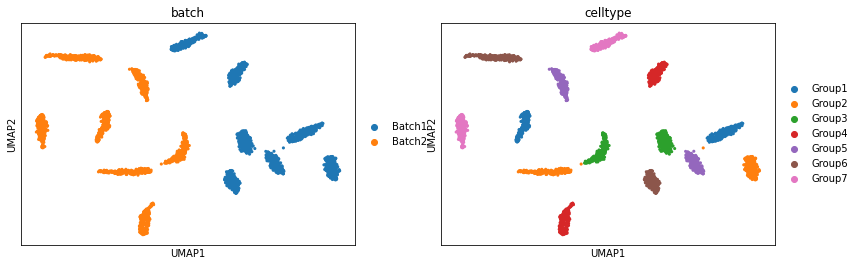



3
(4000, 10000)
zero prop:  0.9536203903095558
(2972, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


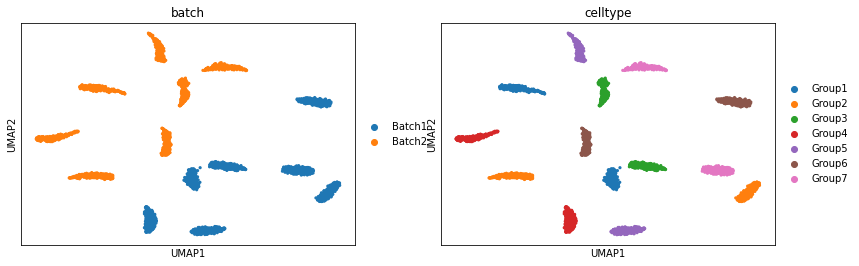



4
(4000, 10000)
zero prop:  0.9505216032188177
(3231, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


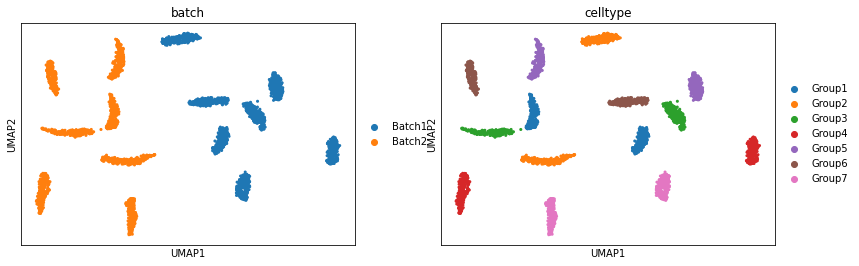



5
(4000, 10000)
zero prop:  0.9504399128268991
(3212, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


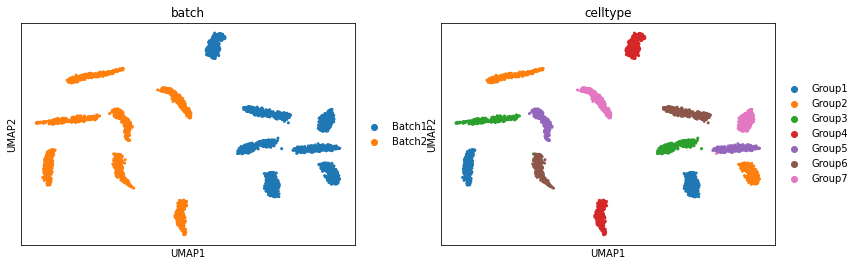



6
(4000, 10000)
zero prop:  0.9517345355888924
(3133, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


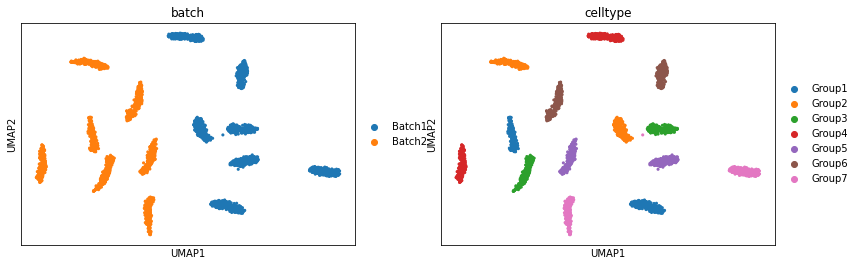



7
(4000, 10000)
zero prop:  0.9533110965200262
(3046, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


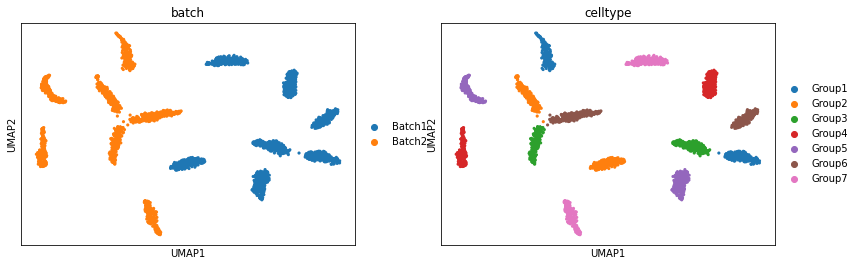



8
(4000, 10000)
zero prop:  0.9503249840662843
(3138, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


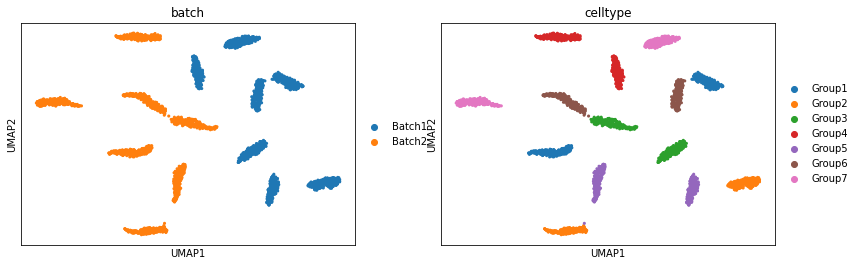



9
(4000, 10000)
zero prop:  0.9508300529430084
(3211, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


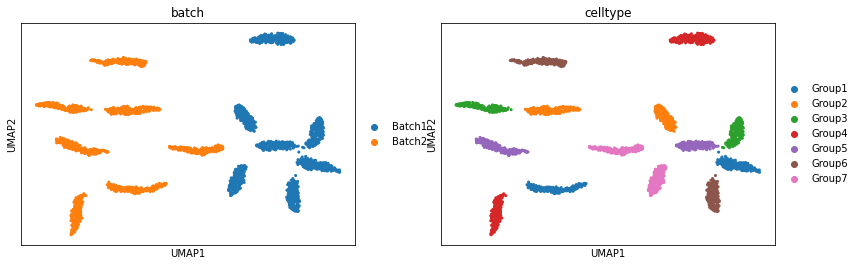



10
(4000, 10000)
zero prop:  0.9519347284345048
(3130, 10000)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


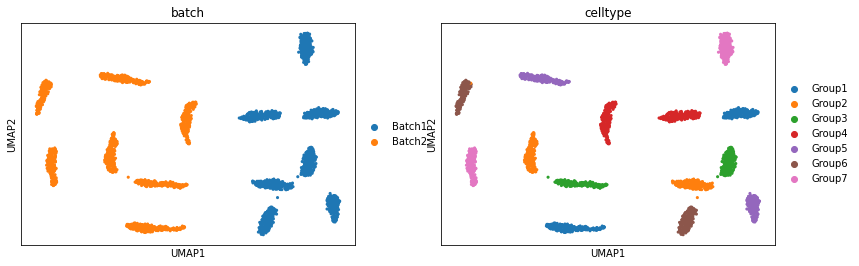

In [254]:
for seed in range(1, 11):
    print('\n')
    print(seed)
    base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim/Sim%d' % seed
    count = pd.read_table('%s/counts.txt' % base_dir)
    print(count.shape)
    cellinfo = pd.read_table('%s/cellinfo.txt' % base_dir)
    geneinfo = pd.read_table('%s/geneinfo.txt' % base_dir)
    adata = sc.AnnData(count.values)
    adata.obs = cellinfo[['Batch', 'Group', 'ExpLibSize']].rename(columns={'Batch': 'batch', 'Group': 'celltype'})
    adata.var = geneinfo
    adata.var_names.name = 'Gene'
    adata.obs_names.name = 'CellID'
    sc.pp.filter_cells(adata, min_genes=200)
#     sc.pp.filter_genes(adata, min_cells=3)
    print('zero prop: ', np.sum(np.sum(adata.X == 0))/np.prod(adata.shape))
    print(adata.shape)
    adata.write_loom('%s/Sim%d_raw.loom' % (base_dir, seed))
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    # adata = adata[:, adata.var['highly_variable']]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, 20, svd_solver='arpack')
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['batch', 'celltype'])

In [13]:
for seed in range(1, 11):
    base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim_new/Sim%d' % seed
    adata = sc.read_loom('%s/Sim%d_raw.loom' % (base_dir, seed))
    print(seed, np.sum(adata.X == 0)/np.prod(adata.shape))

/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


1 0.37914553543874085
2 0.37686859470048456
3 0.38571854972090136
4 0.37325224458204337
5 0.3813230828615543
6 0.3789581442129152
7 0.3841072603021272
8 0.37877876310919184
9 0.3807775175041186
10 0.3887077835051546


# Generate subsampled files for different cases

In [17]:
import os

In [18]:
batch1_ncells = [1000, 500, 250]
rare1_prop_cells = [1/2, 1/5, 1/10]
common_cells = [5, 3, 1]

In [20]:
for seed in range(2, 3):
    base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim_new/Sim%d' % seed
    adata = sc.read_loom('%s/Sim%d_raw.loom' % (base_dir, seed))
    for number in common_cells:
        os.mkdir('%s/common_%d' % (base_dir, number))
        common_ct = ['Group%d' % i for i in range(1, number+1)]
        index0 = adata.obs_names[adata.obs.celltype.isin(common_ct)]
        specific_number = 7 - number
        # Get specific cell types for Batch1
        specific_ct = ['Group%d' % i for i in range(number+1, int(number+1+specific_number/2))]
        index1 = adata.obs_names[adata.obs.celltype.isin(specific_ct) & (adata.obs.batch=='Batch1')]
        # Get specific cell types for Batch2
        specific_ct = ['Group%d' % i for i in range(int(number+1+specific_number/2), 7+1)]
        index2 = adata.obs_names[adata.obs.celltype.isin(specific_ct) & (adata.obs.batch=='Batch2')]
        adata_sub = adata[index0.union(index1).union(index2)]
        print(pd.crosstab(adata_sub.obs.celltype, adata_sub.obs.batch))
        adata_sub.write_loom('%s/common_%d/Sim%d_raw.loom' % (base_dir, number, seed))

batch     Batch1  Batch2
celltype                
Group1       243     224
Group2       239     230
Group3       234     219
Group4       218     220
Group5       213     236
Group6       205       0
Group7         0     205
batch     Batch1  Batch2
celltype                
Group1       243     224
Group2       239     230
Group3       234     219
Group4       218       0
Group5       213       0
Group6         0     236
Group7         0     205
batch     Batch1  Batch2
celltype                
Group1       243     224
Group2       239       0
Group3       234       0
Group4       218       0
Group5         0     236
Group6         0     236
Group7         0     205




2


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


zero prop:  0.9391794572099704
(2266, 7938)


/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/gpfs/gibbs/pi/zhao/yw599/venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'celltype' as categorical


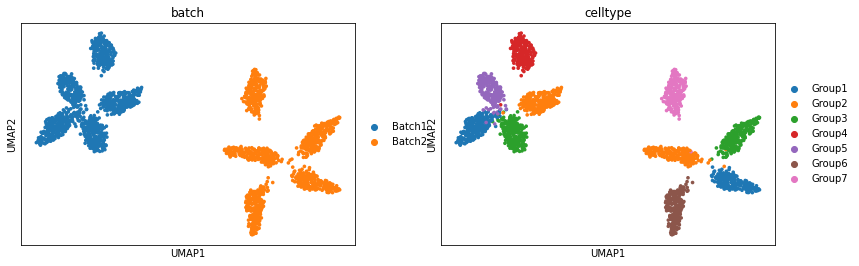

In [349]:
for seed in range(2,3):
    print('\n')
    print(seed)
    base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim/Sim%d/common_3' % seed
    adata = sc.read_loom('%s/Sim%d_raw.loom' % (base_dir, seed))
    print('zero prop: ', np.sum(np.sum(adata.X == 0))/np.prod(adata.shape))
    print(adata.shape)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var['highly_variable']]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, 20, svd_solver='arpack')
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['batch', 'celltype'])

In [21]:
for seed in range(2,3):
    base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim_new/Sim%d' % seed
    adata = sc.read_loom('%s/Sim%d_raw.loom' % (base_dir, seed))
    total = np.sum(adata.obs.celltype == 'Group1')
    for number in rare1_prop_cells:
        os.mkdir('%s/rare1_%.1f' % (base_dir, number))
        obs_names = np.random.choice(adata.obs_names[adata.obs.celltype == 'Group1'], int(total*(1-number)), replace=False)
        adata_sub = adata[~adata.obs_names.isin(obs_names)]
        print(adata_sub.obs.celltype.value_counts())
        adata_sub.write_loom('%s/rare1_%.1f/Sim%d_raw.loom' % (base_dir, number, seed))

Group2    469
Group3    453
Group5    449
Group6    441
Group4    438
Group7    414
Group1    234
Name: celltype, dtype: int64
Group2    469
Group3    453
Group5    449
Group6    441
Group4    438
Group7    414
Group1     94
Name: celltype, dtype: int64
Group2    469
Group3    453
Group5    449
Group6    441
Group4    438
Group7    414
Group1     47
Name: celltype, dtype: int64


In [22]:
for seed in range(2,3):
    base_dir = '/gpfs/gibbs/pi/zhao/yw599/AWGAN/datasets/Sim_new/Sim%d' % seed
    adata = sc.read_loom('%s/Sim%d_raw.loom' % (base_dir, seed))
    batch1_n = np.sum(adata.obs.batch == 'Batch1')
    for number in batch1_ncells:
        os.mkdir('%s/batch1_%d' % (base_dir, number))
        obs_names = np.random.choice(adata.obs_names[adata.obs.batch == 'Batch1'], 
                                     int((1-number/2000)*batch1_n), replace=False)
        adata_sub = adata[~adata.obs_names.isin(obs_names)]
        print(adata_sub.obs.batch.value_counts())
        adata_sub.write_loom('%s/batch1_%d/Sim%d_raw.loom' % (base_dir, number, seed))

Batch2    1570
Batch1     781
Name: batch, dtype: int64
Batch2    1570
Batch1     391
Name: batch, dtype: int64
Batch2    1570
Batch1     196
Name: batch, dtype: int64
